In [31]:
import pandas as pd
from core.oja import Oja
from sklearn.decomposition import PCA
import json


full_data = pd.read_csv("../data/europe.csv")
data = full_data.drop(columns=["Country"])
data = (data - data.mean()) / data.std()

oja_model = Oja(seed=42, num_features=data.shape[1])
pca_model = PCA(n_components=1)

oja_weights = oja_model.fit(data.values, epochs=1000)
pca_model.fit(data)

pca_first_component = pca_model.components_[0]

# Print results
print("Oja :", oja_weights)
print("PCA :", pca_first_component)


Oja rule completed 1000 epochs.
Oja : [ 0.19976932 -0.49045031  0.4767865  -0.50017386  0.13269894 -0.4576239
  0.2335993 ]
PCA : [-0.1248739   0.50050586 -0.40651815  0.48287333 -0.18811162  0.47570355
 -0.27165582]


Converged after 280 epochs.
Sanger's rule completed 280 epochs.
Oja's learned components:
[ 0.19976932 -0.49045031  0.4767865  -0.50017386  0.13269894 -0.4576239
  0.2335993 ]
Sanger's learned components:
[[ 0.19976932 -0.49045031  0.4767865  -0.50017386  0.13269894 -0.4576239
   0.2335993 ]
 [-0.00274537  0.10537504  0.30528379 -0.31039218 -0.7043539  -0.09754602
  -0.52648197]
 [-0.89275205 -0.11665095 -0.24362352 -0.17963651 -0.15432722 -0.11943187
   0.15192784]]

PCA components (transposed):
[[-1.24873902e-01  5.00505858e-01 -4.06518155e-01  4.82873325e-01
  -1.88111616e-01  4.75703554e-01 -2.71655820e-01]
 [-1.72872202e-01 -1.30139553e-01 -3.69657243e-01  2.65247797e-01
   6.58266888e-01  8.26219831e-02  5.53203705e-01]
 [ 8.98296740e-01  8.39557607e-02  1.98194675e-01  2.46082460e-01
   2.43679433e-01  1.63697207e-01  5.00135736e-04]]

Difference between Sanger and PCA components:
[[ 0.07489542  0.01005555  0.07026834 -0.01730054 -0.05541268  0.01807966
  -0.03805652]
 [-0.17561

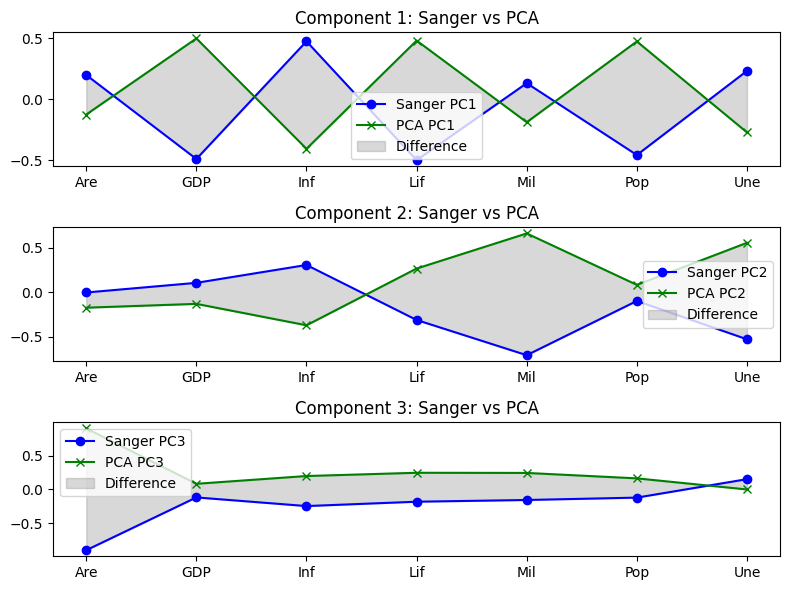

In [32]:
import pandas as pd
from core.oja import Oja
from sklearn.decomposition import PCA
from core.sanger import Sanger
import numpy as np
import matplotlib.pyplot as plt

full_data = pd.read_csv("../data/europe.csv")
data = full_data.drop(columns=["Country"])
data = (data - data.mean()) / data.std()


num_components = 3  
pca_model = PCA(n_components=num_components)
sanger_model = Sanger(seed=42, num_features=data.shape[1], num_components=num_components)

pca_model.fit(data)
sanger_weights = sanger_model.fit(data, epochs=1000)

pca_components = pca_model.components_
#components[:, :num_components].T 


print("Oja's learned components:")
print(oja_weights)

print("Sanger's learned components:")
print(sanger_weights)

print("\nPCA components (transposed):")
print(pca_components)



difference = sanger_weights + pca_components

print("\nDifference between Sanger and PCA components:")
print(difference)

norm_difference = np.linalg.norm(difference, axis=1)
print("\nNorm of the difference between Sanger and PCA components:")
print(norm_difference)

# grab the first 3 letters of each column name
abbreviations = [col[:3] for col in full_data.columns[1:]]

def plot_component_comparison(oja_weights, sanger_weights, pca_components, num_components):
    fig, axes = plt.subplots(num_components, 1, figsize=(8, 6))
    for i in range(num_components):
        axes[i].plot(sanger_weights[i], label=f"Sanger PC{i+1}", marker='o', color='blue')
        
        axes[i].plot(pca_components[i], label=f"PCA PC{i+1}", marker='x', color='green')
        
        axes[i].fill_between(np.arange(len(sanger_weights[i])), sanger_weights[i], pca_components[i], 
                             color='gray', alpha=0.3, label='Difference')
        
        axes[i].set_title(f'Component {i+1}: Sanger vs PCA')
        axes[i].legend()

        # add the name abrebviation of each column in the x-axis
        axes[i].set_xticks(np.arange(len(abbreviations)))
        axes[i].set_xticklabels(abbreviations)

    plt.tight_layout()
    plt.show()

# Call the function to display the comparison
plot_component_comparison(oja_weights, sanger_weights, pca_components, num_components)

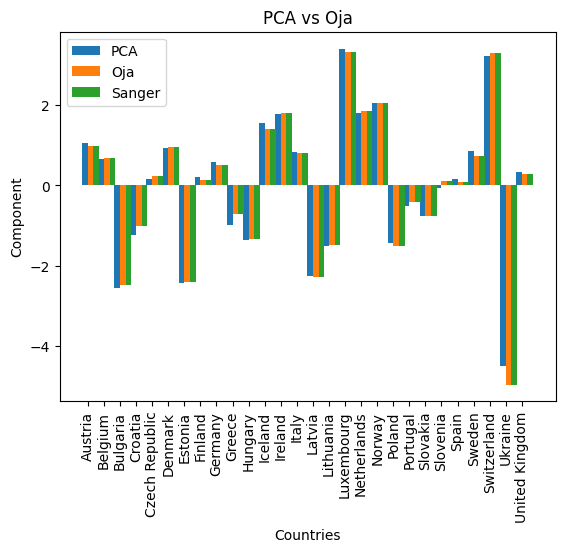

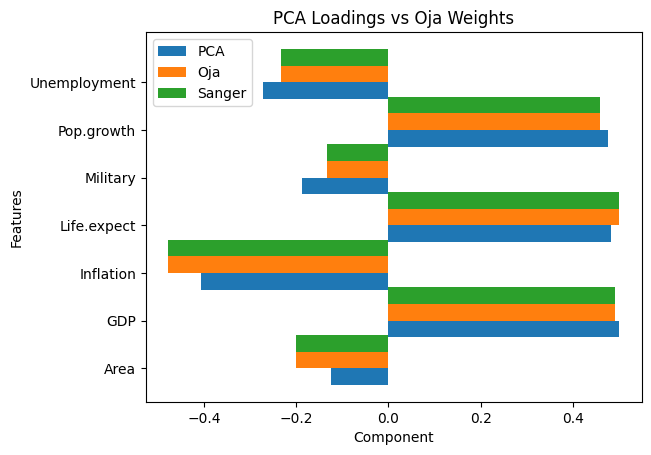

In [33]:
import numpy as np
import matplotlib.pyplot as plt


# Plot the results of PCA vs Oja in a vertical bar plot
# We are going to plot the first component of PCA and Oja
# We are using one vertical bar per country
# Each bar will have two colors, one for PCA and one for Oja

# Get the first component of PCA
components_pca = pca_model.transform(data)
pca_component = components_pca[:, 0]

# gotta get the first component of Oja. I have the weights, but I need to multiply them by the data
oja_component = np.dot(data.values, oja_weights)

# get first component of Sanger
sanger_component = np.dot(data.values, sanger_weights[0])

# make the oja and pca components have the same sign
if np.corrcoef(pca_component, oja_component)[0, 1] < 0:
    oja_component = -oja_component

# make the sanger and pca components have the same sign
if np.corrcoef(pca_component, sanger_component)[0, 1] < 0:
    sanger_component = -sanger_component

# Get the countries
countries = full_data["Country"]

# Create the figure
fig, ax = plt.subplots()

# Create the index
index = np.arange(len(countries))

# Create the width of the bars
bar_width = 0.35

# Create the bars
pca_bars = ax.bar(index, pca_component, bar_width, label="PCA")
oja_bars = ax.bar(index + bar_width, oja_component, bar_width, label="Oja")
sanger_bars = ax.bar(index + 2*bar_width, sanger_component, bar_width, label="Sanger")

# Set the labels
ax.set_xlabel('Countries')
ax.set_ylabel('Component')
ax.set_title('PCA vs Oja')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(countries, rotation=90)
ax.legend()

# Show the plot
plt.show()


# Plot the results of PCA loadings vs Oja weights
# We are using a horizontal bar plot to compare the loadings of PCA and the weights of Oja

# Get the loadings of PCA
loadings_pca = pca_model.components_[0]

# Create the index
index = np.arange(len(loadings_pca))

# Create the figure
fig, ax = plt.subplots()

# make the oja weights have the same sign as the pca loadings
if np.corrcoef(loadings_pca, oja_weights)[0, 1] < 0:
    oja_weights = -oja_weights

# make the sanger weights have the same sign as the pca loadings
if np.corrcoef(loadings_pca, sanger_weights[0])[0, 1] < 0:
    sanger_weights = -sanger_weights

# Create the bars
pca_bars = ax.barh(index, loadings_pca, bar_width, label="PCA")
oja_bars = ax.barh(index + bar_width, oja_weights, bar_width, label="Oja")
sanger_bars = ax.barh(index + 2*bar_width, sanger_weights[0], bar_width, label="Sanger")

# Set the labels
ax.set_xlabel('Component')
ax.set_ylabel('Features')
ax.set_title('PCA Loadings vs Oja Weights')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(full_data.columns[1:], rotation=0)
ax.legend()

# Show the plot
plt.show()

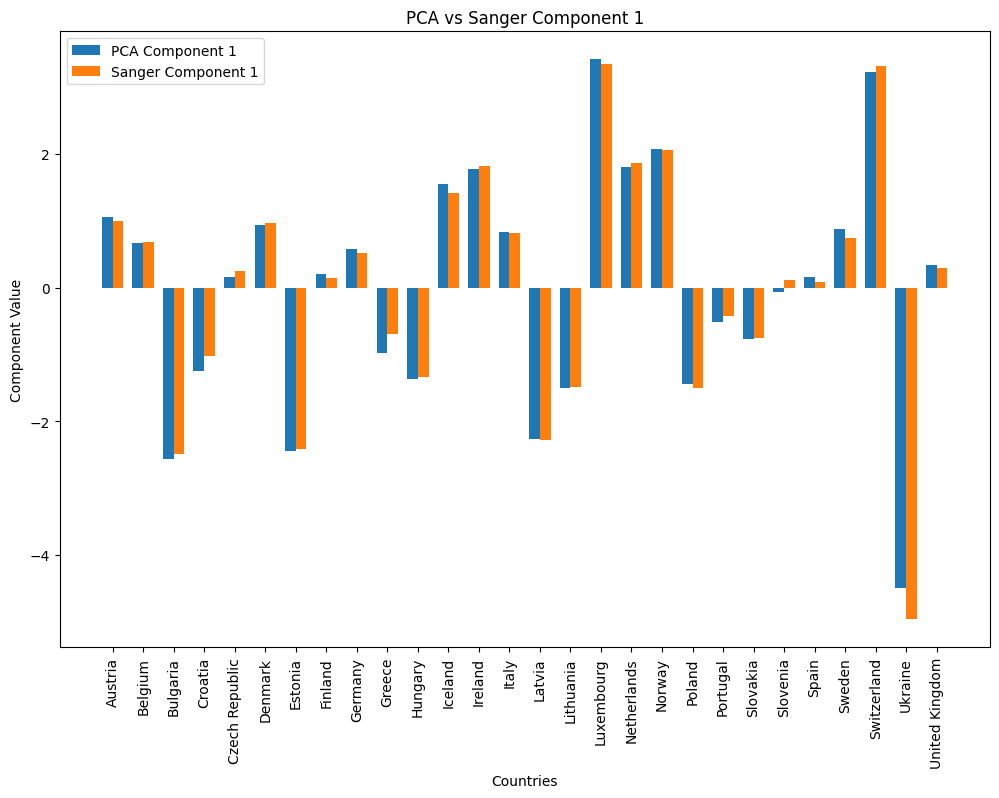

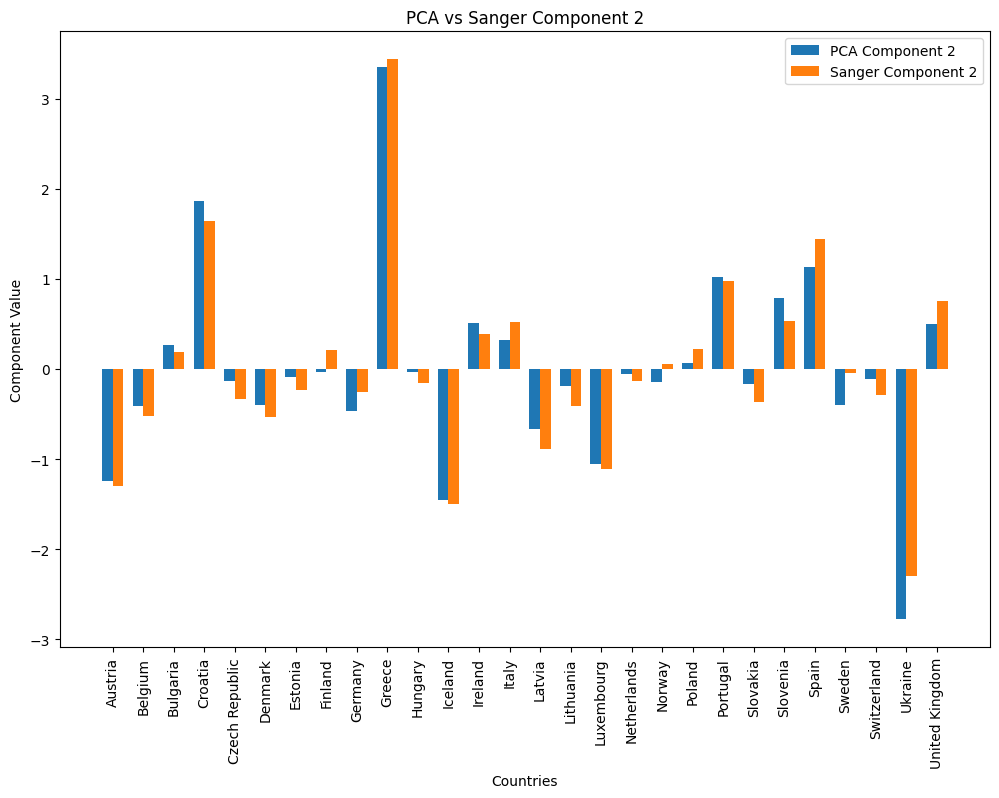

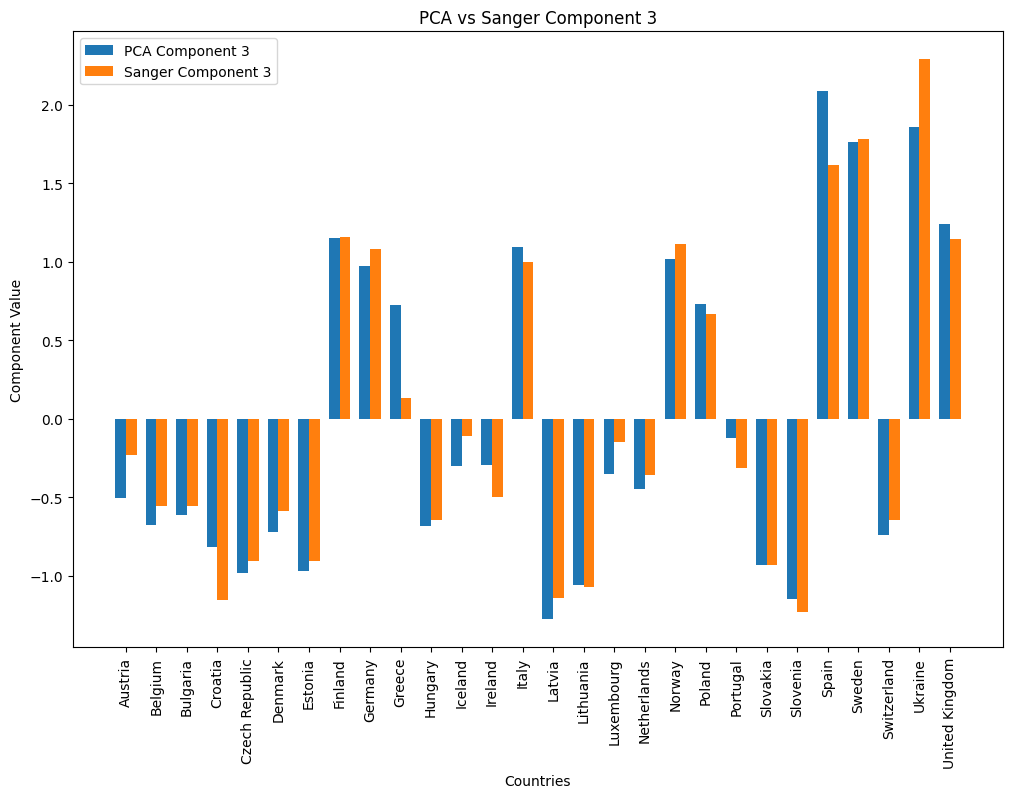

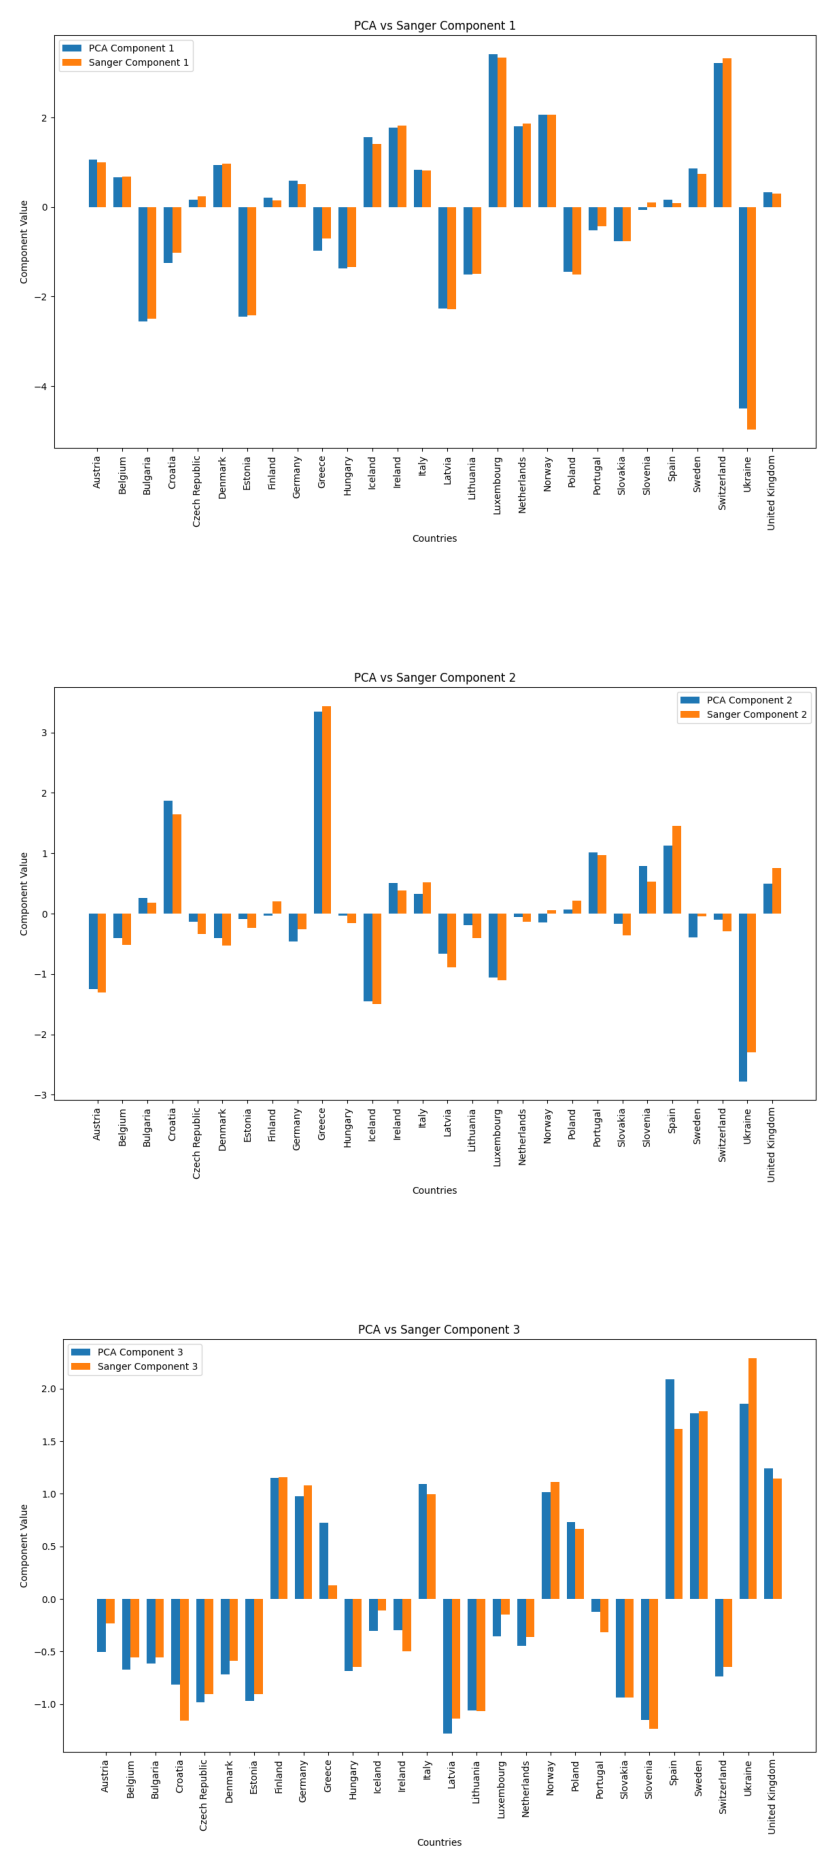

In [34]:
fig_axs = []
# Plot the results of PCA components vs Sanger components
def plot_component_comparison(sanger_weights, pca_components, num_components):

    # create results directory if it does not exist
    import os
    if not os.path.exists("../results"):
        os.makedirs("../results")

    for i in range(num_components):
        fig, ax = plt.subplots(figsize=(12, 8))

        fig_axs.append((fig, ax))

        pca_component = pca_components[:, i]
        sanger_component = np.dot(data.values, sanger_weights[i])

        # Adjust the sign of Sanger component to match PCA component
        if np.corrcoef(pca_component, sanger_component)[0, 1] < 0:
            sanger_component = -sanger_component

        index = np.arange(len(countries))
        bar_width = 0.35

        ax.bar(index, pca_component, bar_width, label=f"PCA Component {i+1}")
        ax.bar(index + bar_width, sanger_component, bar_width, label=f"Sanger Component {i+1}")

        ax.set_xlabel('Countries')
        ax.set_ylabel('Component Value')
        ax.set_title(f'PCA vs Sanger Component {i+1}')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(countries, rotation=90)
        ax.legend()

        # save the figure
        fig.savefig(f"../results/PCA_vs_Sanger_{i+1}.png")
        plt.show()

plot_component_comparison(sanger_weights, components_pca, num_components)


# make a graphic with the 3 previous graphics
fig, axs = plt.subplots(3, 1, figsize=(12, 24))

for i, (fig, ax) in enumerate(fig_axs):
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.tight_layout()
    fig.savefig(f"../results/PCA_vs_Sanger_{i+1}.png")
    axs[i].imshow(fig.canvas.renderer._renderer)
    axs[i].axis("off")

plt.show()


Converged after 280 epochs.
Sanger's rule completed 280 epochs.


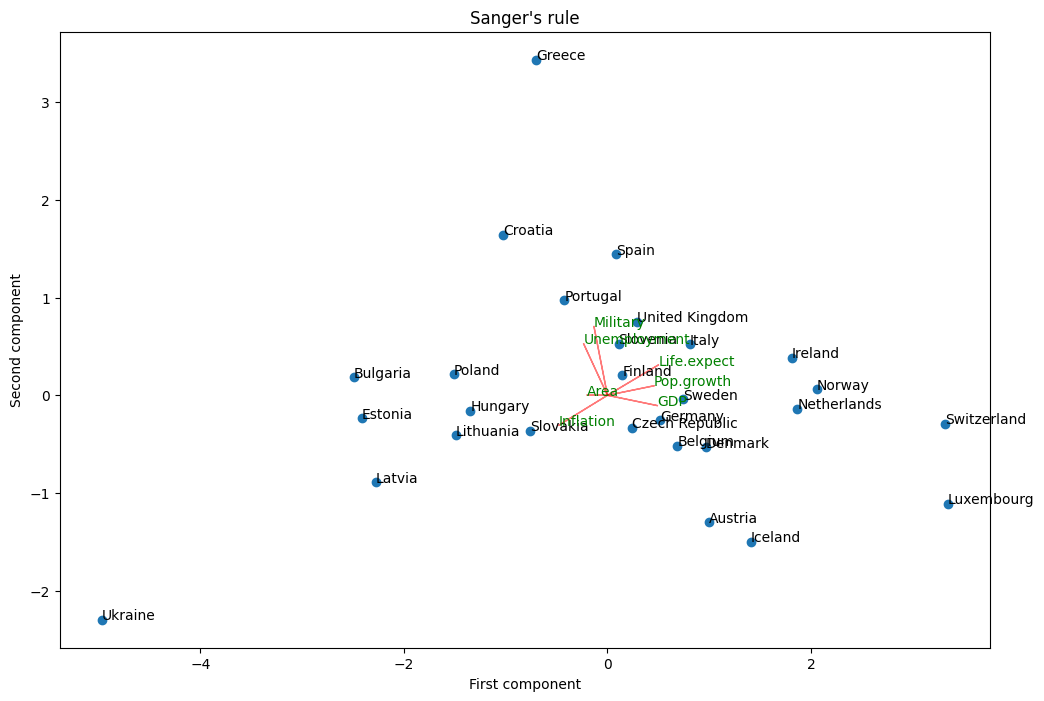

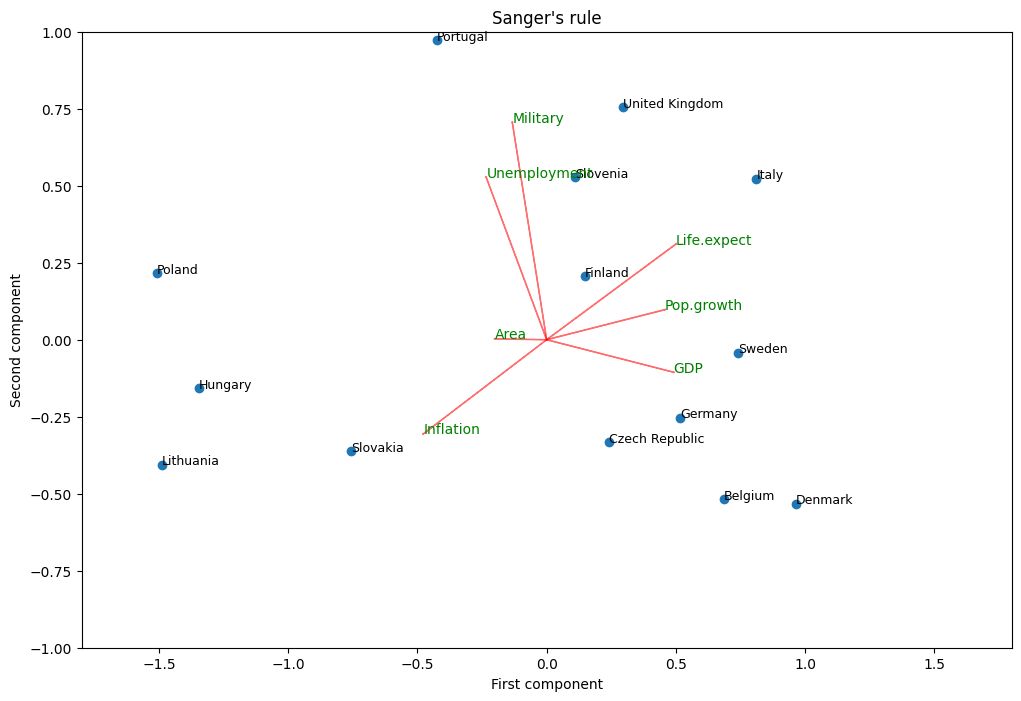

In [35]:
import matplotlib.pyplot as plt
from core.sanger import Sanger

# Now we use Sanger's rule to obtain the weights but with constant learning rate
sanger = Sanger(seed=42, num_features=data.shape[1], num_components=num_components)

# Fit the data
sanger_weights = sanger.fit(data.values, epochs=10000)

# Get the first two components of Sanger
sanger_lodaings_pc1 = sanger_weights[0]
sanger_lodaings_pc2 = sanger_weights[1]

# invert the signs of the components to match the PCA components
if np.corrcoef(components_pca[:, 0], np.dot(data.values, sanger_lodaings_pc1))[0, 1] < 0:
    sanger_lodaings_pc1 = -sanger_lodaings_pc1

if np.corrcoef(components_pca[:, 1], np.dot(data.values, sanger_lodaings_pc2))[0, 1] < 0:
    sanger_lodaings_pc2 = -sanger_lodaings_pc2

# get the first two components of the data
sanger_component1 = np.dot(data.values, sanger_lodaings_pc1)
sanger_component2 = np.dot(data.values, sanger_lodaings_pc2)

plt.figure(figsize=(12, 8))

plt.scatter(sanger_component1, sanger_component2)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.title("Sanger's rule")

# Add country names to the dots
for i, country in enumerate(countries):
    plt.text(sanger_component1[i], sanger_component2[i], country)

# plot the loadings
features = full_data.columns[1:]
for i, feature in enumerate(full_data.columns[1:]):
    plt.arrow(0, 0, sanger_lodaings_pc1[i], sanger_lodaings_pc2[i], color="red", alpha=0.5)
    plt.text(sanger_lodaings_pc1[i], sanger_lodaings_pc2[i], features[i], color="green")

plt.show()


# we zoom in the plot
# Filter the data to include only points within the specified limits

x1, x2, y1, y2 = -1.8, 1.8, -1, 1
filtered_indices = (sanger_component1 >= x1) & (sanger_component1 <= x2) & (sanger_component2 >= y1) & (sanger_component2 <= y2)
filtered_sanger_component1 = sanger_component1[filtered_indices]
filtered_sanger_component2 = sanger_component2[filtered_indices]
filtered_countries = full_data.iloc[filtered_indices, 0].values  # Assuming the first column contains country names
filtered_sanger_countries = filtered_countries

plt.figure(figsize=(12, 8))  # Increase the figure size

plt.scatter(filtered_sanger_component1, filtered_sanger_component2)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.title("Sanger's rule")

# Add country names to the dots
for i in range(len(filtered_countries)):
    plt.text(filtered_sanger_component1[i], filtered_sanger_component2[i], filtered_countries[i], fontsize=9)

# We plot the loadings
for i in range(len(features)):
    if x1 <= sanger_lodaings_pc1[i] <= x2 and y1 <= sanger_lodaings_pc2[i] <= y2:
        plt.arrow(0, 0, sanger_lodaings_pc1[i], sanger_lodaings_pc2[i], color='r', alpha=0.5)
        plt.text(sanger_lodaings_pc1[i], sanger_lodaings_pc2[i], features[i], color='g')

# Set the x and y limits
plt.xlim(x1, x2)
plt.ylim(y1, y2)

plt.show()



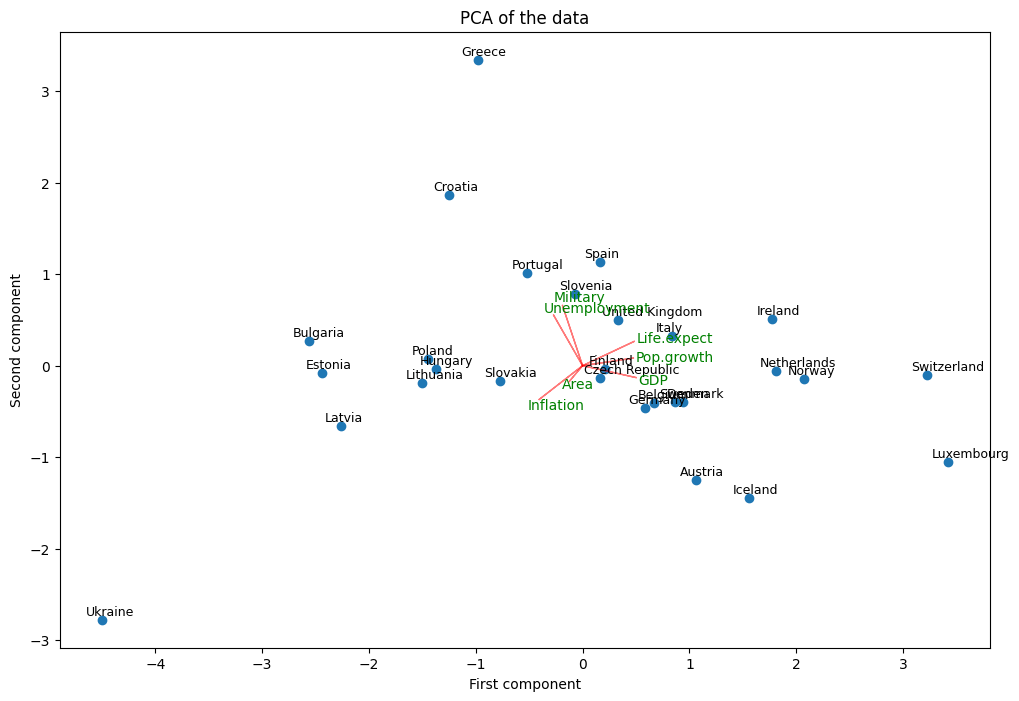

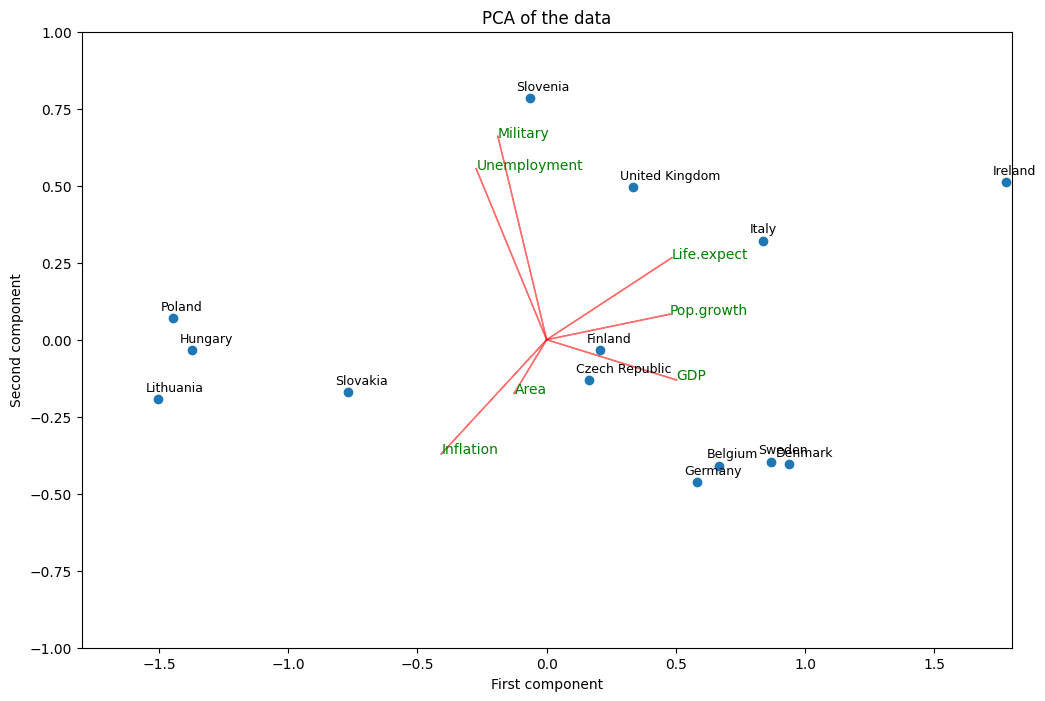

In [36]:
# we make the PCA biplot
import matplotlib.pyplot as plt

# now we make the biplot for the first two components
# we plot the data

components = pca_model.transform(data)

plt.figure(figsize=(12, 8))  # Increase the figure size

plt.scatter(components[:, 0], components[:, 1])
plt.xlabel("First component")
plt.ylabel("Second component")
plt.title("PCA of the data")

# Add country names to the dots
countries = full_data.iloc[:, 0].values  # Assuming the first column contains country names
for i in range(len(countries)):
    plt.text(components[i, 0] - 0.15, components[i, 1] + 0.05, countries[i], fontsize=9)

# we plot the loadings
for i in range(len(features)):
    plt.arrow(0, 0, pca_model.components_[0, i], pca_model.components_[1, i], color='r', alpha=0.5)
    plt.text(pca_model.components_[0, i]*1.15 - 0.05, pca_model.components_[1, i]*1.15 - 0.05, features[i], color='g')

plt.show()

# we zoom in the plot
# Filter the data to include only points within the specified limits
x1, x2, y1, y2 = -1.8, 1.8, -1, 1
filtered_indices = (components[:, 0] >= x1) & (components[:, 0] <= x2) & (components[:, 1] >= y1) & (components[:, 1] <= y2)
filtered_components = components[filtered_indices]
filtered_countries = full_data.iloc[filtered_indices, 0].values  # Assuming the first column contains country names

plt.figure(figsize=(12, 8))  # Increase the figure size

plt.scatter(filtered_components[:, 0], filtered_components[:, 1])
plt.xlabel("First component")
plt.ylabel("Second component")
plt.title("PCA of the data")

# Add country names to the dots
for i in range(len(filtered_countries)):
    plt.text(filtered_components[i, 0] - 0.05, filtered_components[i, 1] + 0.025, filtered_countries[i], fontsize=9)

# We plot the loadings
for i in range(len(features)):
    if x1 <= pca_model.components_[0, i] <= x2 and y1 <= pca_model.components_[1, i] <= y2:
        plt.arrow(0, 0, pca_model.components_[0, i], pca_model.components_[1, i], color='r', alpha=0.5)
        plt.text(pca_model.components_[0, i], pca_model.components_[1, i], features[i], color='g')

# Set the x and y limits
plt.xlim(x1, x2)
plt.ylim(y1, y2)

plt.show()

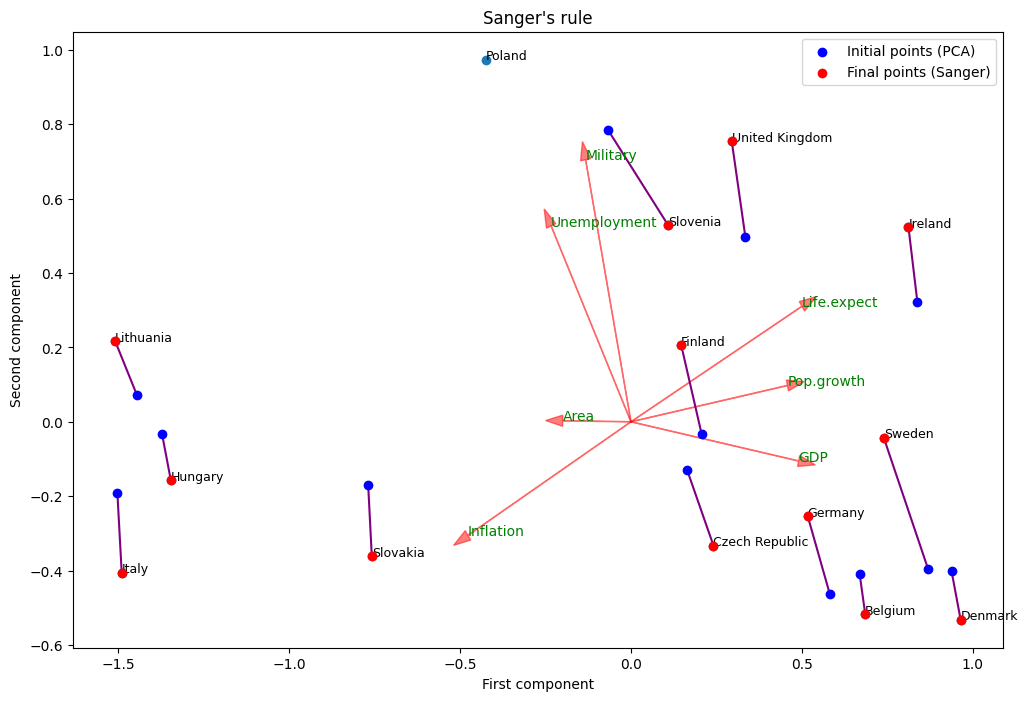

In [56]:
# Now, for the zoomed in pictures of Sanger and PCA, I want to draw the path that each country moved (From PCA to Sanger)

# I already have the filtered countries for PCA in the variable filtered_countries, and the filtered countries of Sanger in filtered_sanger_countries

# I will create a dictionary with the paths of each country
country_paths = {}

# I will iterate over the countries
for country in filtered_countries:
    # I will get the index of the country in the PCA and Sanger data
    pca_indices = np.where(countries == country)[0]
    sanger_indices = np.where(filtered_sanger_countries == country)[0]

    # Check if the country exists in both lists
    if len(pca_indices) > 0 and len(sanger_indices) > 0:
        pca_index = pca_indices[0]
        sanger_index = sanger_indices[0]

        # I will get the coordinates of the country in the PCA and Sanger data
        pca_coordinates = components[pca_index][:2]  # Ensure we only take the first two components
        sanger_coordinates = np.array([filtered_sanger_component1[sanger_index], filtered_sanger_component2[sanger_index]])

        # I will create the path
        path = np.vstack([pca_coordinates, sanger_coordinates])

        # I will add the path to the dictionary
        country_paths[country] = path

# plot the PCA and Sanger plots
plt.figure(figsize=(12, 8))

plt.scatter(filtered_sanger_component1, filtered_sanger_component2)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.title("Sanger's rule")

# Add country names to the dots
for i in range(len(filtered_countries)):
    plt.text(filtered_sanger_component1[i], filtered_sanger_component2[i], filtered_countries[i], fontsize=9)

# plot the loadings with arrows
for i in range(len(features)):
    if x1 <= sanger_lodaings_pc1[i] <= x2 and y1 <= sanger_lodaings_pc2[i] <= y2:
        plt.arrow(0, 0, sanger_lodaings_pc1[i], sanger_lodaings_pc2[i], color='r', alpha=0.5,
                  head_width=0.03, head_length=0.05)
        plt.text(sanger_lodaings_pc1[i], sanger_lodaings_pc2[i], features[i], color='g')

# plot the paths of the countries
for country, path in country_paths.items():
    plt.plot(path[:, 0], path[:, 1], color='purple', label='_nolegend_')  # Path color set to purple
    # Plot the initial and final points
    plt.scatter(path[0, 0], path[0, 1], color='blue', zorder=5)  # Initial point (PCA)
    plt.scatter(path[1, 0], path[1, 1], color='red', zorder=5)   # Final point (Sanger)

# Add a legend for the initial and final points
plt.scatter([], [], color='blue', label='Initial points (PCA)')
plt.scatter([], [], color='red', label='Final points (Sanger)')

plt.legend()
plt.show()